In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.multiprocessing.spawn import spawn
import torchvision.datasets as dst
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import DataLoader, DistributedSampler


In [2]:
z_dim = 100
num_classes = 10

def expand_label(y, H, W):
        # y: (B,) int ラベル → (B, C, H, W) one-hot レプリケート
        onehot = torch.zeros(y.size(0), num_classes, H, W, device=y.device)
        onehot.scatter_(1, y.view(-1,1,1,1).repeat(1,1,H,W), 1)
        return onehot

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input: (z_dim + num_classes)×1×1
            nn.ConvTranspose2d(z_dim + num_classes, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # → 256×7×7
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # → 128×14×14
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # → 64×28×28
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Tanh()
            # 出力: 1×28×28
        )
    def forward(self, z, y):
        # z: (B, z_dim), y: (B,) int
        B = z.size(0)
        z = z.view(B, z_dim, 1, 1)
        y_map = expand_label(y, 1, 1)         # (B, C, 1, 1)
        x = torch.cat([z, y_map], dim=1)      # (B, z_dim+C,1,1)
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        # input: (1 + num_classes)×28×28
        nn.Conv2d(1 + num_classes, 64, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),
        # → 64×14×14
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # → 128×7×7
        nn.Conv2d(128, 256, 3, 2, 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # → 256×4×4
        nn.Flatten(),
        nn.Linear(256*4*4, 1),
        nn.Sigmoid()
    )
    def forward(self, img, y):
        # img: (B,1,28,28), y: (B,)
        B = img.size(0)
        y_map = expand_label(y, 28, 28)       # (B,C,28,28)
        x = torch.cat([img, y_map], dim=1)    # (B,1+C,28,28)
        return self.net(x)

/tmp/ipykernel_1290444/3685869222.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("6_3_cdcgan.pth", map_location=device))


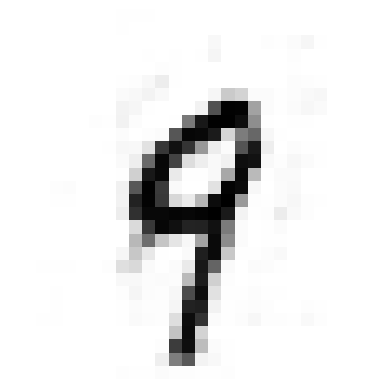

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
G.load_state_dict(torch.load("6_3_cdcgan.pth", map_location=device))
G = nn.DataParallel(G)

# 検証
G.eval()
with torch.no_grad():
    z = torch.randn(1, 100, device=device)
    label = torch.tensor([9], device=device)  
    fake_imgs = G(z, label)                # → Tensor [16, img_dim]
    fake_imgs = fake_imgs.view(1, 1, 28, 28)
    fake_imgs = fake_imgs[0,0].cpu().numpy()

# 可視化
fake_imgs = (fake_imgs + 1.0) / 2.0  
plt.imshow(fake_imgs, cmap='gray')
plt.axis('off')
plt.show()